# Angular Correlations of Amorphous Materials

This notebook demonstrates caclulating the angular correlation of diffraction patterns recorded from an amorphous (or crystalline) material.

The dataset used for this demonstration is a 4-D STEM dataset of a PdNiP deposited thin film glass aquired using a DE-16 Camera and a 200keV FEI-Titan electron microscopt at 100 fps.  The probe size was ~2-nm and step size was .365 nm so there there is singificant probe overlap in the probe positions.

This functionality has been checked to run with pyxem-0.15.0 (April 2023). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

## Background

Angular Correlations are a very natural extension to variance type studies. They offer more insight into the symmetry of the strucutures being studied as well as offering the ability to be studied spatially.  

Mathmatically, the Angular correlation is the angular-autocorrelation of some polar unwrapped diffraction pattern I(k). 

<p style="text-align: center;">
$ C(k,\phi) = \frac{<I(k, \theta)*I(k, \theta+\phi)>_\theta - <I(k,\theta)>^2_\theta }{<I(k, \theta)>^2_\theta} $
</p>

This is simlar to the radial ("r") variance often calculated in Fluctuation Electron Microscopy.


## Contents

1. <a href='#loa'> Importing & Visualization</a>
2. <a href='#s2'> Polar Reprojection</a>
3. <a href='#s3'> Angular Correlation</a>
4. <a href='#s4'> Power Spectrum and Correlation Maps</a>

<a id='s1'></a> 

## 1 - Importing and Visualization

This section goes over loading the data from the data folder and visualizing the data for further use. 

In [1]:
data_path = "data/09/PdNiP_test.hspy"

In [2]:
%matplotlib inline
import pyxem as pxm
import hyperspy.api as hs

In [3]:
pxm.__version__

'0.15.0'

In [4]:
data = hs.load("./data/09/PdNiP_test.hspy")

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


<a id='s2'></a> 

##  2 - Polar Reprojection
 
This section deals with converting the signal to a polar signal.  This is probably the most important and difficult part of the analysis.  Even small distortions in the pattern or misinterpertation of the center of the diffraction pattern will negitively affect the ability to determine correlations.

There is still some ongoing development on methods for identifying and correcting for these distortions but a good check is always to perform the correct and make sure that the first amorphous ring is a line after the polar reprojection.  In general your eye should be very good at identifying that.  Another thing to notice is that after the correlation if you have small splititing in all of your peaks(especially the self correlation) then most likely your center isn't completely correct.

In [5]:
data.set_signal_type("electron_diffraction")
data.beam_energy=200
data.unit = "k_nm^-1"


In [6]:
mask =data.get_direct_beam_mask(20)

In [7]:
# Affine correction from fitting an ellipse
import numpy as np
center=(31.2,31.7)
affine=np.array([[ 1.03725511, -0.02662789,  0.        ],
                 [-0.02662789,  1.01903215,  0.        ],
                 [ 0.        ,  0.        ,  1.        ]])

In [8]:
data.set_ai(center=center)
rad = data.get_azimuthal_integral2d(npt=100)

[                                        ] | 0% Completed |  0.1s

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


[########################################] | 100% Completed |  3.3s


**Note:** This isn't perfect, as you can see there is still some distortion that an affine transformation could fix, but for the purposes of this demo this it will suffice

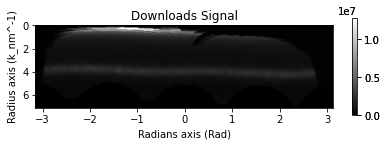

In [9]:
rad.sum().plot()

<a id='s3'></a>

##   3 - Angular Correlations
 
This section deals with converting the signal to a correlation signal.  The most important part here is to properly mask the data.  This is important for example if you have a beam stop

In [10]:
summed = rad.sum()
mask = ((summed>4e6)+(summed<3e5))

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


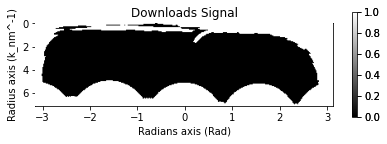

In [11]:
mask.plot()

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


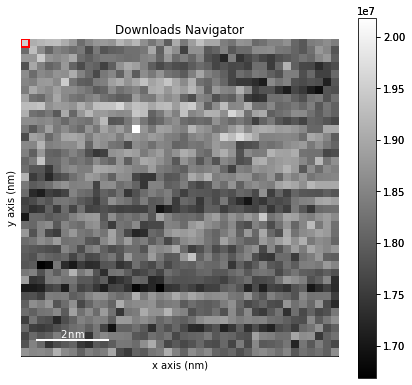

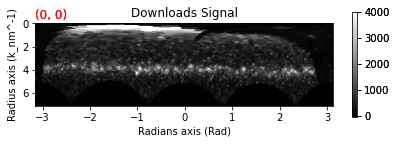

In [12]:
rad.plot(vmax=4000)

In [13]:
cor = rad.get_angular_correlation(mask=mask)

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


[                                        ] | 0% Completed |  0.0s

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


[########################################] | 100% Completed |  0.5s


/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


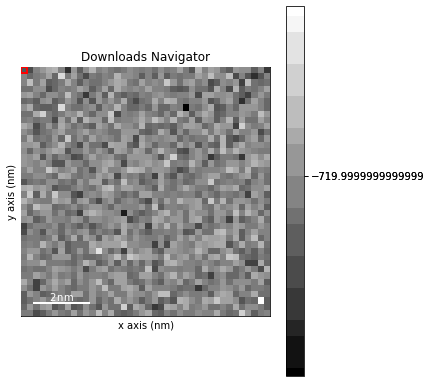

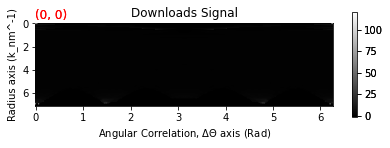

In [14]:
cor.plot()

In [15]:
cor = rad.map(pxm.utils.correlation_utils._correlation, inplace=False, axis=1, normalize=True)

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


[                                        ] | 0% Completed |  0.0s

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


[########################################] | 100% Completed |  0.3s


/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


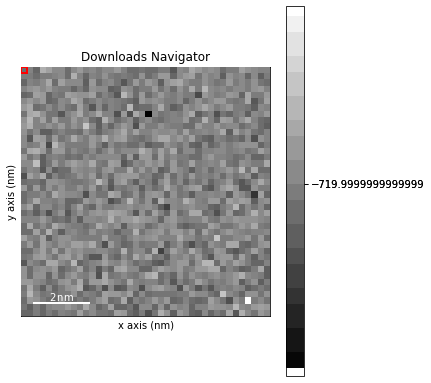

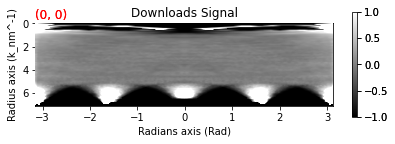

In [16]:
cor.isig[:].plot(vmax=1, vmin=-1)

<a id='s4'></a>

##   4 - Power Spectrum and Correlation Maps
 
This section deals with visualization of the correlations as correlation maps.  These are spatial maps of the strucutre in some material. 

In [17]:
power = cor.get_angular_power()

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


[                                        ] | 0% Completed |  0.1s

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


[########################################] | 100% Completed |  0.2s


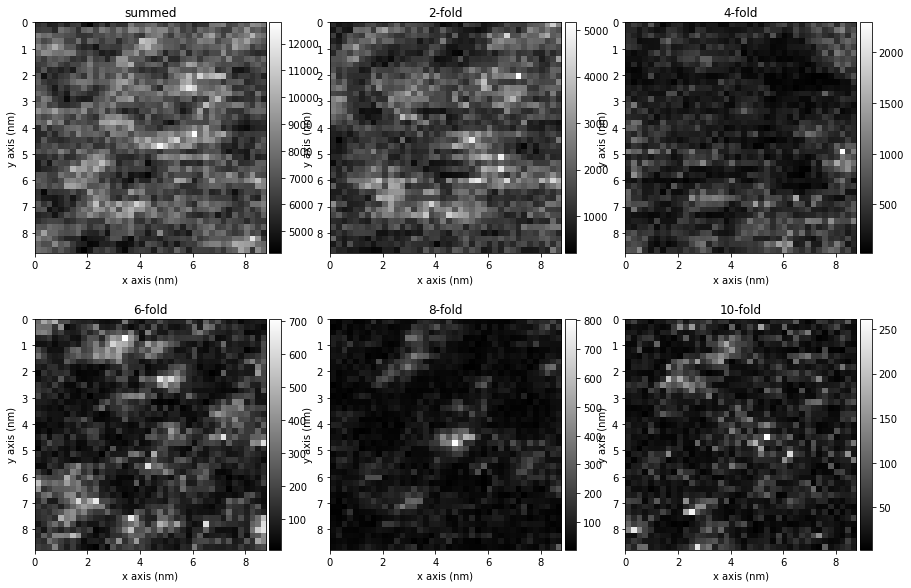

In [18]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,10))
power.plot_symmetries(k_region = [3.,4.5],fig=f)